# Transports over SSH=-1.2m contour for sigma_2 bins

These were obtained by 
1. defining SSH=-1.2m contour (defined in /g/data/x77/cy8964/Honours/Hotspot_contours/SO_SSH_contours.ipynb), 
2. extracting values of volume transport, layer thickness, salt and temp along that contour for 10 years (/g/data/x77/cy8964/Analysis/New_SO/calc_everything_SO_new_pot_rho_2.py), and then 
3. binning it into sigma2 bins (/g/data/x77/cy8964/Analysis/New_SO/calc_contour_binning_sigma2.py)

the files of interest:
- /g/data/x77/cy8964/Post_Process/New_SO/SO_L_latlon.nc which has the lat lon coordinates of this contour
- /g/data/x77/cy8964/Post_Process/New_SO/SO_L_distance_along_contour.nc which has distance along contour
- /g/data/x77/cy8964/Post_Process/New_SO/sigma2contour/SO_L_vol_trans_across_contour_binned.nc, volume transport across contour in sigma2 bins for 10 years
- /g/data/x77/cy8964/Post_Process/New_SO/sigma2contour/SO_L_dzu_along_contour_binned.nc, layer thickness at contour in sigma2 bins for 10 years

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cftime
import glob
import dask
import os
import datetime
import matplotlib.colors as col
import dask.array as dsa
from cosima_cookbook import distributed as ccd
import cartopy.crs as ccrs
import cmocean as cm
from scipy.ndimage.filters import uniform_filter1d
import scipy.stats as ss
from collections import OrderedDict
from matplotlib import gridspec

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client()
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/contextlib.py:126: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/contextlib.py:126: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36783,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://10.6.122.51:33787,Total threads: 4
Dashboard: /proxy/43023/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:46079,


In [3]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

### Load important parameters

In [4]:
expt = '01deg_jra55v13_ryf9091'

# reference density value:
rho_0 = 1035.0
g = 9.81

### Load 10 year datasets of transport and layer thickness in density coordinates

In [5]:
save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/sigma2contour/SO_L_'
h = xr.open_dataset(save_dir+'dzu_along_contour_binned.nc').dzu_along_contour_binned
vh = xr.open_dataset(save_dir+'vol_trans_across_contour_binned.nc').vol_trans_across_contour_binned

In [7]:
## load mean (v_bar*h_bar) and residual ((vh)_bar)
v = vh/h
v = v.where(v!=np.inf).where(v !=-np.inf).fillna(0)
v_bar = v.mean('time')
v_bar.load()

h_bar = h.mean('time')
h_bar.load()

vh_mean = v_bar*h_bar

vh_residual = vh.mean('time')
vh_residual.load()

<xarray.DataArray 'vol_trans_across_contour_binned' (isopycnal_bins: 49, contour_index: 5764)>
array([[-6.91703879e+01,  4.77089217e+02, -6.74525776e+01, ...,
         7.98823405e+00, -1.62318925e+01, -2.62504296e+01],
       [-3.11005444e+04,  1.89519243e+05, -3.00669491e+04, ...,
        -7.84679402e+02, -1.03085676e+04, -1.40603851e+04],
       [-4.97383427e+03,  2.55656497e+04, -4.78236357e+03, ...,
        -8.45686316e+02, -2.12107984e+03, -2.53388957e+03],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])
Coordinates:
  * isopycnal_bins  (isopycnal_bins) float64 1.0 36.5 36.52 ... 37.4 37.42 38.0
  * contour_index   (contour_index) int64 1 2 3 4 5 ... 5760 5761 5762 5763 5764

In [8]:
# load eddy
vh_eddy = (v-v_bar)*(h-h_bar)
vh_eddy = vh_eddy.mean('time')
vh_eddy.load()

<xarray.DataArray (isopycnal_bins: 49, contour_index: 5764)>
array([[-1.14909367e+01,  7.27349000e+01, -1.17040632e+01, ...,
         3.39601073e+00, -5.23526777e-01, -2.64602300e+00],
       [-3.33807688e+03,  1.56433898e+04, -3.05420893e+03, ...,
         3.12575542e+02, -4.85794684e+02, -9.08625495e+02],
       [-1.31541689e+03,  7.96337377e+03, -1.28893224e+03, ...,
         4.29292164e+01, -3.67312788e+02, -5.29263673e+02],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])
Coordinates:
  * isopycnal_bins  (isopycnal_bins) float64 1.0 36.5 36.52 ... 37.4 37.42 38.0
  * contour_index   (contour_index) int64 1 2 3 4 5 ... 5760 5761 5762 5763 5764

In [63]:
vh_eddy.isopycnal_bins.values

array([ 1.  , 36.5 , 36.52, 36.54, 36.56, 36.58, 36.6 , 36.62, 36.64,
       36.66, 36.68, 36.7 , 36.72, 36.74, 36.76, 36.78, 36.8 , 36.82,
       36.84, 36.86, 36.88, 36.9 , 36.92, 36.94, 36.96, 36.98, 37.  ,
       37.02, 37.04, 37.06, 37.08, 37.1 , 37.12, 37.14, 37.16, 37.18,
       37.2 , 37.22, 37.24, 37.26, 37.28, 37.3 , 37.32, 37.34, 37.36,
       37.38, 37.4 , 37.42, 38.  ])

#### Find which densities have northward and southward eddy transport on average

Text(0.5, 0, 'eddy transport in density layer (Sv)')

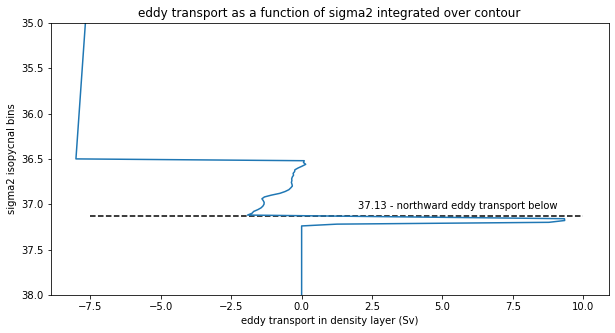

In [78]:
fig, ax = plt.subplots(figsize = (10,5))
(vh_eddy.sum('contour_index')/1e6).plot(ax = ax,y = 'isopycnal_bins')
ax.set_title('eddy transport as a function of sigma2 integrated over contour')
ax.set_ylim(38,35)
ax.hlines(37.13,-7.5,10, color = 'k', linestyle = '--')
ax.text(2,37.05,'37.13 - northward eddy transport below')
ax.set_ylabel('sigma2 isopycnal bins')
ax.set_xlabel('eddy transport in density layer (Sv)')

2625.7799520679628


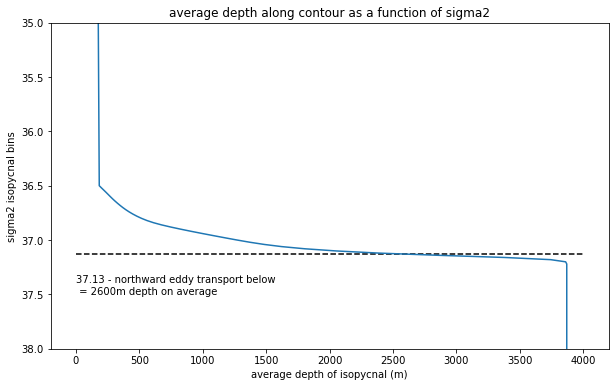

In [80]:
fig, ax = plt.subplots(figsize = (10,6))
(h_bar.cumsum('isopycnal_bins').mean('contour_index')).plot(ax = ax,y = 'isopycnal_bins')
ax.set_title('average depth along contour as a function of sigma2')
ax.set_ylim(38,35)
ax.hlines(37.13,0,4000, color = 'k', linestyle = '--')
ax.text(2,37.5,'37.13 - northward eddy transport below \n = 2600m depth on average')

ax.set_ylabel('sigma2 isopycnal bins')
ax.set_xlabel('average depth of isopycnal (m)')
print((h_bar.cumsum('isopycnal_bins').mean('contour_index').sel(isopycnal_bins = 37.12, method = 'nearest').values+
      h_bar.cumsum('isopycnal_bins').mean('contour_index').sel(isopycnal_bins = 37.14, method = 'nearest').values)/2)

A bottom water cutoff of sigma_2 = 1037.13 equates to about 2600m depth

In [13]:
def find_contour_index_positions_of_given_longitudes(j_contour):
    lon_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_latlon.nc').lon_along_contour

    # run above distance indices code
    distance_indices = np.zeros(8)
    for i in np.arange(100,len(lon_along_contour.values)):
        if (distance_indices[1]==0):
            if (lon_along_contour.values[i]>-240):
                distance_indices[1] = lon_along_contour.contour_index.values[i]
        if (distance_indices[2]==0):
            if (lon_along_contour.values[i]>-180):
                distance_indices[2] = lon_along_contour.contour_index.values[i]
        if (distance_indices[3]==0):
            if (lon_along_contour.values[i]>-120):
                distance_indices[3] = lon_along_contour.contour_index.values[i]
        if (distance_indices[4]==0):
            if lon_along_contour.values[i]>-60:
                distance_indices[4] = lon_along_contour.contour_index.values[i]
        if (distance_indices[5]==0):
            if (lon_along_contour.values[i]>0):
                distance_indices[5] = lon_along_contour.contour_index.values[i]
        if (distance_indices[6]==0):
            if (lon_along_contour.values[i]>60):
                distance_indices[6] = lon_along_contour.contour_index.values[i]
    distance_indices[7] = len(lon_along_contour.contour_index.values)-1
    return distance_indices

Text(0.5, 1.0, 'SSH= -1.2 m')

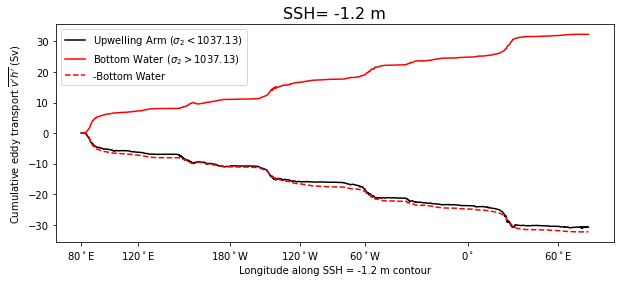

In [81]:
j_contour = 'L'
rhoslice_up = slice(0,37.13)
rhoslice_bottom = slice(37.13,38)
SSH = -1.2
save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_'
distance = xr.open_dataset(save_dir+'distance_along_contour.nc').distance
distance_indices = find_contour_index_positions_of_given_longitudes(j_contour)

fig = plt.figure(figsize = (10,4))
plt.plot(distance,vh_eddy.sel(isopycnal_bins = rhoslice_up).sum('isopycnal_bins').cumsum('contour_index')/1e6,color = 'k', label = 'Upwelling Arm ($\sigma_2 <1037.13$)')
plt.plot(distance,vh_eddy.sel(isopycnal_bins = rhoslice_bottom).sum('isopycnal_bins').cumsum('contour_index')/1e6,color = 'r', label = 'Bottom Water ($\sigma_2 >1037.13$)')
plt.plot(distance,-vh_eddy.sel(isopycnal_bins = rhoslice_bottom).sum('isopycnal_bins').cumsum('contour_index')/1e6,color = 'r',linestyle = '--', label = '-Bottom Water')
plt.xticks(distance.values[distance_indices.astype(int)[:-1]], 
           ('80$^\circ$E','120$^\circ$E','180$^\circ$W','120$^\circ$W','60$^\circ$W','0$^\circ$','60$^\circ$E'));
plt.legend()
plt.xlabel('Longitude along SSH = '+str(SSH)+' m contour')
plt.ylabel('Cumulative eddy transport $\overline{v^\prime h^\prime}$ (Sv)')
plt.title('SSH= '+str(SSH)+' m', fontsize = 16)

eddy total
32.33334450155895
mean total
-13.055501547627326
residual total
19.277842953931607


Text(0.5, 1.0, 'SSH= -1.2 m')

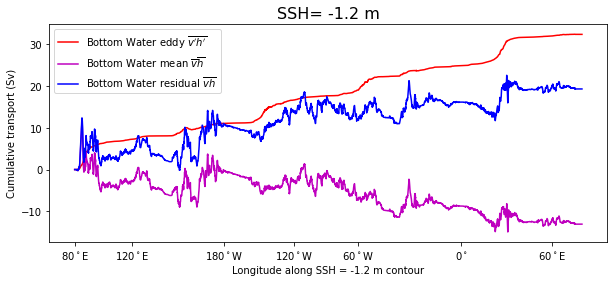

In [82]:
j_contour = 'L'
SSH = -1.2
rhoslice_bottom = slice(37.13,38)
save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_'

distance = xr.open_dataset(save_dir+'distance_along_contour.nc').distance
distance_indices = find_contour_index_positions_of_given_longitudes(j_contour)
fig = plt.figure(figsize = (10,4))
plt.plot(distance,vh_eddy.sel(isopycnal_bins = rhoslice_bottom).sum('isopycnal_bins').cumsum('contour_index')/1e6,color = 'r', label = 'Bottom Water eddy $\overline{v^\prime h^\prime}$')
plt.plot(distance,vh_mean.sel(isopycnal_bins = rhoslice_bottom).sum('isopycnal_bins').cumsum('contour_index')/1e6,color = 'm', label = 'Bottom Water mean $\overline{v}\overline{h}$')
plt.plot(distance,vh_residual.sel(isopycnal_bins = rhoslice_bottom).sum('isopycnal_bins').cumsum('contour_index')/1e6,color = 'b', label = 'Bottom Water residual $\overline{vh}$')

plt.xticks(distance.values[distance_indices.astype(int)[:-1]], 
           ('80$^\circ$E','120$^\circ$E','180$^\circ$W','120$^\circ$W','60$^\circ$W','0$^\circ$','60$^\circ$E'));
plt.legend()
plt.xlabel('Longitude along SSH = '+str(SSH)+' m contour')
plt.ylabel('Cumulative transport (Sv)')
print('eddy total')
print(vh_eddy.sel(isopycnal_bins = rhoslice_bottom).sum('isopycnal_bins').sum('contour_index').values/1e6)
print('mean total')
print(vh_mean.sel(isopycnal_bins = rhoslice_bottom).sum('isopycnal_bins').sum('contour_index').values/1e6)
print('residual total')
print(vh_residual.sel(isopycnal_bins = rhoslice_bottom).sum('isopycnal_bins').sum('contour_index').values/1e6)
plt.title('SSH= '+str(SSH)+' m', fontsize = 16)

# The same calculation for a deep Montgomery Potential contour:

A contour chosen by MP in sigma_1 = 1032.58 (very deep) layer (purple) that is close to the SSH=-1.2m contour (blue) (I don't have MP in sigma_2 layers)

CPU times: user 1.6 s, sys: 328 ms, total: 1.93 s
Wall time: 3.79 s


Text(0.5, 0, 'Longitude')

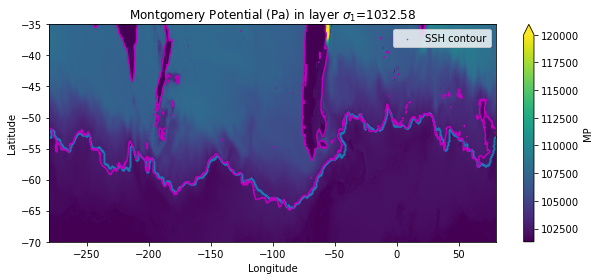

In [6]:
%%time
MP = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/MP_10yr.nc').MP

L = 'SO_ocean_contour_smoothed_u_t_-1.2m_SSH_plt_approach.npz'
outfile = '/g/data/x77/cy8964/Post_Process/'+L
data = np.load(outfile)
lon_along_contour=data['lon_along_contour_t']
lat_along_contour=data['lat_along_contour_t']

fig = plt.figure(figsize = (10,4))
MP.sel(isopycnal_bins =1032.58).plot(vmax = 120000)
MP.sel(isopycnal_bins =1032.58).plot.contour(levels = [102650],colors = 'm')
plt.scatter(lon_along_contour,lat_along_contour,label = 'SSH contour',s = 0.3)
plt.legend()
plt.title('Montgomery Potential (Pa) in layer $\sigma_1$=1032.58')
plt.ylabel('Latitude')
plt.xlabel('Longitude')

load contour info

In [8]:
save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/sigma2contour/SO_L_MP_deep_'
h = xr.open_dataset(save_dir+'dzu_along_contour_binned.nc').dzu_along_contour_binned
vh = xr.open_dataset(save_dir+'vol_trans_across_contour_binned.nc').vol_trans_across_contour_binned

In [9]:
%%time
## load mean (v_bar*h_bar) and residual ((vh)_bar)
v = vh/h
v = v.where(v!=np.inf).where(v !=-np.inf).fillna(0)
v_bar = v.mean('time')
v_bar.load()

h_bar = h.mean('time')
h_bar.load()

vh_mean = v_bar*h_bar

vh_residual = vh.mean('time')
vh_residual.load()
# load eddy
vh_eddy = (v-v_bar)*(h-h_bar)
vh_eddy = vh_eddy.mean('time')
vh_eddy.load()

CPU times: user 3min 7s, sys: 52.9 s, total: 4min
Wall time: 3min 49s


<xarray.DataArray (isopycnal_bins: 49, contour_index: 7368)>
array([[  -135.33797939,   -122.03395869,   -141.85142688, ...,
           -81.42439529,    -95.76409222,   -117.00618294],
       [-11654.45528249, -10208.15718959, -14832.32323282, ...,
        -11265.66464124, -10504.74790123, -10387.1962683 ],
       [  -152.84686284,    -92.67096358,    526.42468669, ...,
           376.21156855,    280.02395832,     90.56560104],
       ...,
       [     0.        ,      0.        ,      0.        , ...,
             0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        ,      0.        , ...,
             0.        ,      0.        ,      0.        ],
       [     0.        ,      0.        ,      0.        , ...,
             0.        ,      0.        ,      0.        ]])
Coordinates:
  * isopycnal_bins  (isopycnal_bins) float64 1.0 36.5 36.52 ... 37.4 37.42 38.0
  * contour_index   (contour_index) int64 1 2 3 4 5 ... 7364 7365 7366 7367 7368

eddy total
32.344819899109496
mean total
-13.201808956172421
residual total
19.143010942937064


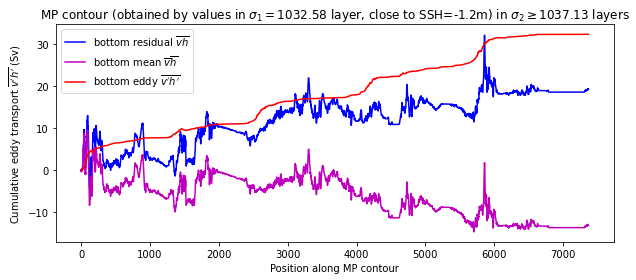

In [10]:
fig = plt.figure(figsize = (10,4))
rhoslice = slice(37.13,40)
(vh_residual.sel(isopycnal_bins = rhoslice).sum('isopycnal_bins').cumsum('contour_index')/1e6).plot(color = 'b', label = 'bottom residual $\overline{vh}$')
(vh_mean.sel(isopycnal_bins = rhoslice).sum('isopycnal_bins').cumsum('contour_index')/1e6).plot(color = 'm', label = 'bottom mean $\overline{v}\overline{h}$')
(vh_eddy.sel(isopycnal_bins = rhoslice).sum('isopycnal_bins').cumsum('contour_index')/1e6).plot(color = 'r', label = 'bottom eddy $\overline{v^\prime h^\prime }$')

plt.legend()
plt.xlabel('Position along MP contour')
plt.ylabel('Cumulative eddy transport $\overline{v^\prime h^\prime}$ (Sv)')
plt.title('MP contour (obtained by values in $\sigma_1=1032.58$ layer, close to SSH=-1.2m) in $\sigma_2\geq 1037.13$ layers', fontsize = 12)
print('eddy total')
print(vh_eddy.sel(isopycnal_bins = rhoslice).sum('isopycnal_bins').sum('contour_index').values/1e6)
print('mean total')
print(vh_mean.sel(isopycnal_bins = rhoslice).sum('isopycnal_bins').sum('contour_index').values/1e6)
print('residual total')
print(vh_residual.sel(isopycnal_bins = rhoslice).sum('isopycnal_bins').sum('contour_index').values/1e6)